# A Ramsey model with hand-to-mouth households

**Table of contents**<a id='toc0_'></a>    
- 1. [Model descripton](#toc1_)    
- 2. [Solution](#toc2_)    
- 3. [Comparison with scipy solution](#toc3_)    
- 4. [Persistent technology shock](#toc4_)    
- 5. [Future persistent technology shock](#toc5_)    
- 6. [Potential analysis and extensions](#toc6_)    
- 7. [Further perspectives](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [50]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from RamseyModel import RamseyModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Model descripton](#toc0_)

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Two infinitely-lived households.

**Households:** We have two types of households: Optimizing households and hand-to-mouth households. The hand-to-mouth households differ from the optimizing (Ricardian) households in that they cannot accumulate savings and are credit-constrained. Therefore, they consume cash-on-hand in every period. Both types of households supply labor exogenously, $N_{t}=1$, and earns a wage $w_{t}$. The return on saving is $r_{t+1}$. The problem for each household is written below.

$\;$

**Optimizing households:**
$$
\begin{aligned}
U^{Opt} & =\max_{\{C^{Opt}_{t}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty}\beta^{t}\frac{({C_{t}}^{Opt})^{1-\sigma}}{1-\sigma},\beta\in(0,1),\sigma>0\\
 & \text{s.t.}\\
 A_{t}^{Opt}&=M_{t}^{Opt}-C_{t}^{Opt} \\
 M_{t}^{Opt}&=(1+r_{t})A_{t-1}^{Opt}+w_{t} N_{t} \lambda
\end{aligned}
$$

**Hand-to-mouth households:**
$$
\begin{aligned}
U^{Htm} & =\max_{\{C_{t}^{Htm}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty}\beta^{t}\frac{({C_{t}}^{Htm})^{1-\sigma}}{1-\sigma},\beta\in(0,1),\sigma>0\\
 & \text{s.t.}\\
 M_{t}^{Htm}&=w_{t}N_{t}(1-\lambda)
\end{aligned}
$$

**Total cash-on-hand, assets and consumption:**
$$
\begin{aligned}
M_t &= M_t^{Opt} + M_t^{Htm} \\
C_t &= C_t^{Opt} + C_t^{Htm} \\
A_t &= A_t^{Opt}
\end{aligned}
$$

Note that $\lambda$ is the share of optimizing households.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$
and hires labor $L_{t}$ at the wage rate $w_{t}$. Firms have access to the CES production function
    
$$
\begin{aligned}
Y_{t} &= F(K_{t-1},L_{t}) \\ &=\Gamma_t(\alpha K_{t-1}^{-\theta}+(1-\alpha)L_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1),\Gamma_t>0
\end{aligned}
$$

Profits are

$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Equilibrium:**

1. Hand-to-mouth households consume all cash-on-hand, $M_t^{Htm}$
2. Optimizing households maximize utility by $C_t^{Opt}$
3. Firms maximize profits, $\Pi_t$
4. Labor market clear: $L_{t}=N_{t}=1$
5. Goods market clear: $Y_{t}=C_{t}+I_{t}$
6. Asset market clear: $A_{t}=K_{t}$ and $r_{t}=r_{t}^{k}-\delta$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & = F_{K}(K_{t-1},L_{t})=A_t \alpha K_{t-1}^{-\theta-1}Y_{t}^{-1}\\
w_{t} & = F_{L}(K_{t-1},L_{t})=A_t (1-\alpha)L_{t}^{-\theta-1}Y_{t}^{-1}
\end{aligned}
$$

**Implication of utility maximization:** From FOCs

$$
\begin{aligned}
C_t^{Htm} &= w_t N_t (1-\lambda) \\
(C_{t}^{Opt})^{-\sigma}&=\beta(1+r_{t+1})(C_{t+1}^{Opt})^{-\sigma} \\
&=\beta(1+F_{K}(K_{t},1)-\delta)(C_{t+1}^{Opt})^{-\sigma}
\end{aligned}
$$

**Simpler capital accumulation equation:** 

$$
\begin{aligned}
K_{t} &= (1-\delta)K_{t-1}+I_{t} \\
&= (1-\delta)K_{t-1}+Y_{t}-C_{t} \\
&= (1-\delta)K_{t-1} + F(K_{t-1},1)-C_{t}
\end{aligned}
$$

## 2. <a id='toc2_'></a>[Solution](#toc0_)

**Solution algorithm:** 

We can summarize the model in the **non-linear equation system**

$$
\begin{aligned}
\boldsymbol{H}(\boldsymbol{K},\boldsymbol{C},K_{-1})=\left[\begin{array}{c}
H_{0}\\
H_{1}\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]=\left[\begin{array}{c}
0\\
0\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]
\end{aligned}
$$

where $\boldsymbol{K} = [K_0,K_1\dots]$, $\boldsymbol{C} = [C_0,C_1\dots]$, and

$$
\begin{aligned}
H_{t}
=\left[\begin{array}{c}
C_{t}^{-\sigma}-\beta(1+F_{K}(K_{t},1))C_{t+1}^{-\sigma}\\
K_{t}-[(1-\delta)K_{t-1} + F(K_{t-1},1)-C_{t}]
\end{array}\right]
\end{aligned}
$$

**Note:** We can verify all equilibrium conditions are fulfilled.

**Path:** We refer to $\boldsymbol{K}$ and $\boldsymbol{C}$ as *transition paths*.

**Implementation:** Assume all variables are in steady  state after some **truncation horizon**. We solve equation system above in **two steps**:

1. Calculate the numerical **jacobian** of $\boldsymbol{H}$ wrt. $\boldsymbol{K}$
and $\boldsymbol{C}$ around the steady state
2. Solve the equation system using a **hand-written Broyden-solver**

**Note:** The equation system can also be solved directly using `scipy.optimize.root`.

**Remember:** The jacobian is just a gradient. I.e. the matrix of what the implied errors are in $\boldsymbol{H}$ when a *single* $K_t$ or $C_t$ change.

**Initialize:**

In [119]:
model = RamseyModelClass()
path = model.path
par = model.par
ss = model.ss

initializing the model:
calling .setup()
calling .allocate()


**Find steady state:** 

1. Target steady-state capital-output ratio, $K_{ss}/Y_{ss}$ of 4.0.
2. Force steady-state output $Y_{ss} = 1$.
3. Adjust $\beta$ and $\Gamma_{ss}$ to achieve this.

In [120]:
model.find_steady_state(KY_ss=4.0)

Y_ss = 1.0000
K_ss/Y_ss = 4.0000
rk_ss = 0.0714
r_ss = 0.0214
w_ss = 0.7144
Gamma = 0.6664
beta = 0.9790
C_opt_ss = 0.1571
C_htm_ss = 0.6429
C_ss = 0.8000


**Test that errors and the path are 0:**

In [121]:
# a. set initial value
par.K_lag_ini = ss.K

# b. set path
path.Gamma[:] = ss.Gamma
path.C_opt[:] = ss.C_opt
path.C_htm[:] = ss.C_htm
path.C[:] = ss.C
path.K[:] = ss.K

# c. check errors
errors_ss = model.evaluate_path_errors(do_print=True)

Error_euler: 0.0
Error_capital: 0.0


**Calculate Jacobian:**

In [122]:
model.calculate_jacobian()

**Solve:**

In [123]:
par.K_lag_ini = 0.50*ss.K # start away from steady state
model.solve() # find transition path

 it =   0 -> max. abs. error =   1.95961554
 it =   1 -> max. abs. error =   0.68296518
 it =   2 -> max. abs. error =   1.67354176
 it =   3 -> max. abs. error =  34.84736000
 it =   4 -> max. abs. error =   9.45937635
 it =   5 -> max. abs. error =  14.06461487
 it =   6 -> max. abs. error =   1.46189048
 it =   7 -> max. abs. error =   0.84433998
 it =   8 -> max. abs. error =   0.14205329
 it =   9 -> max. abs. error =   0.08455975
 it =  10 -> max. abs. error =   0.04715622
 it =  11 -> max. abs. error =   0.01923798
 it =  12 -> max. abs. error =   0.01268293
 it =  13 -> max. abs. error =   0.00381951
 it =  14 -> max. abs. error =   0.00197903
 it =  15 -> max. abs. error =   0.00046606
 it =  16 -> max. abs. error =   0.00021522
 it =  17 -> max. abs. error =   0.00006581
 it =  18 -> max. abs. error =   0.00001741
 it =  19 -> max. abs. error =   0.00001512
 it =  20 -> max. abs. error =   0.00000149
 it =  21 -> max. abs. error =   0.00000164
 it =  22 -> max. abs. error =  

**Plot:**

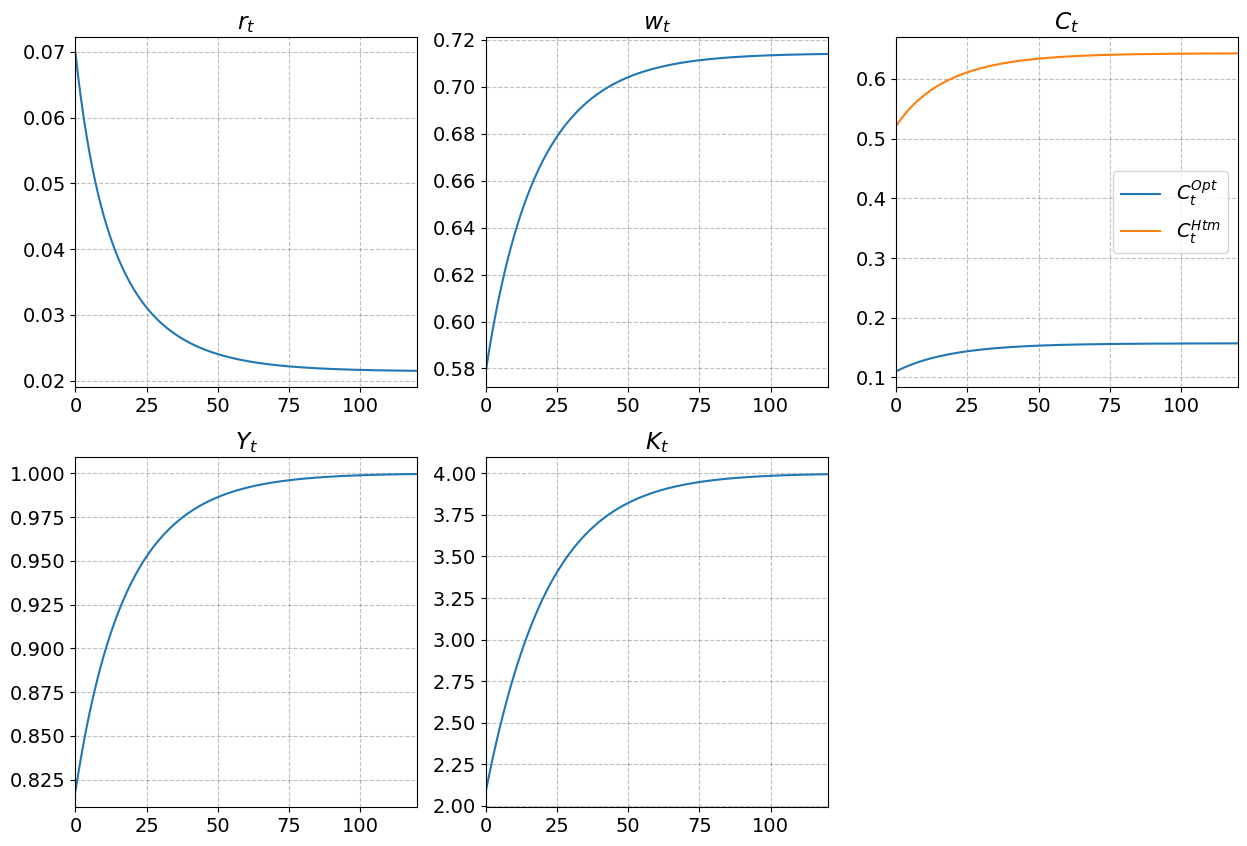

In [124]:
model.big_plot()

**Economic intution:** Solving the model with $K_{t-1}$ initially being out of steady state (50 pct. of steady state) yields the transition paths above. Capital grows as households save more, $A_t \uparrow$, and investments increase, $I_t \uparrow$. This follows from the Euler equation in which marginal utility today must equal the discounted marginal utility tomorrow. The trade off is that less consumption today allows for more consumption tomorrow. <br>

Because of a greater production input, $K_{t-1} \uparrow$, production grows, $Y_t \uparrow$, allowing for more consumption, $C_t \uparrow$. The return on capital decreases, $r_t \downarrow$, due to law of diminishing returns. However, the wage increases, $w_t \uparrow$, because growing capital makes the workforce $L_t$ increasingly more productive. <br>

Since the hand-to-mouth households cannot save, $A_t^{Htm} = 0$, one would expect that the convergence to steady state takes longer as the share of hand to mouth households grows, $(1-\lambda) \uparrow$. Let's test this hypothesis.

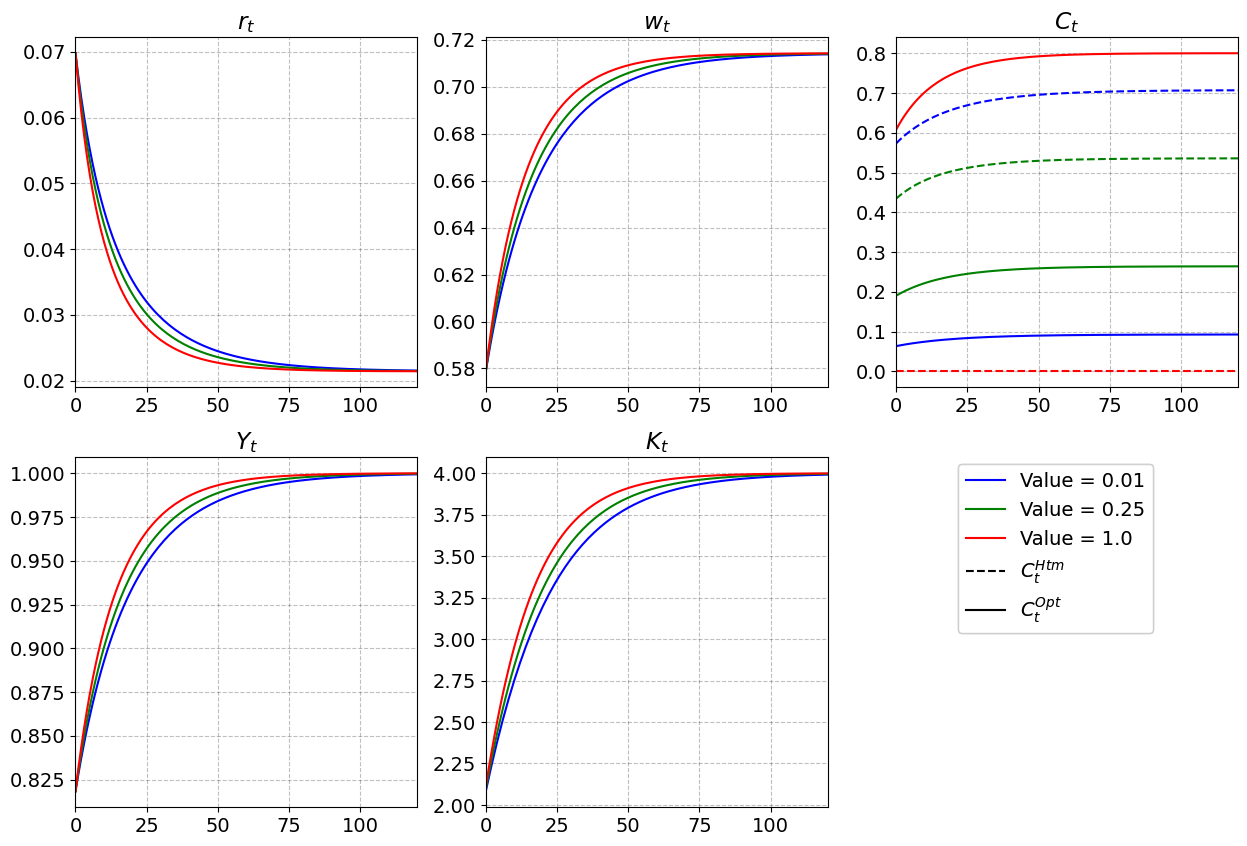

In [116]:
# values of lambda
values = [0.01,0.25,1.0]

# solve model for each value of lambda
model.simulate_and_plot('lambdaa',values)

## 3. <a id='toc3_'></a>[Comparison with scipy solution](#toc0_)

**Note:** scipy computes the jacobian internally

In [8]:
model_scipy = RamseyModelClass()
model_scipy.par.solver = 'scipy'
model_scipy.find_steady_state(KY_ss=4.0)
model_scipy.par.K_lag_ini = 0.50*model_scipy.ss.K
model_scipy.path.Gamma[:] = model_scipy.ss.Gamma
model_scipy.solve()

initializing the model:
calling .setup()
calling .allocate()
Y_ss = 1.0000
K_ss/Y_ss = 4.0000
rk_ss = 0.0750
r_ss = 0.0250
w_ss = 0.7000
Gamma = 0.6598
beta = 0.9756


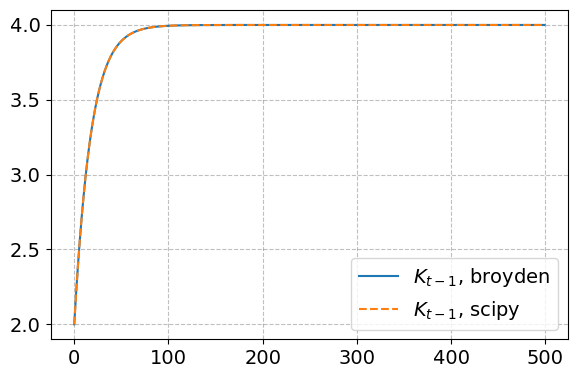

In [9]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(path.K_lag,label=r'$K_{t-1}$, broyden')
ax.plot(model_scipy.path.K_lag,ls='--',label=r'$K_{t-1}$, scipy')
ax.legend(frameon=True)
fig.tight_layout()

## 4. <a id='toc4_'></a>[Persistent technology shock](#toc0_)

**Shock:**

In [10]:
par.K_lag_ini = ss.K # start from steady state
path.Gamma[:] = 0.95**np.arange(par.Tpath)*0.1*ss.Gamma + ss.Gamma # shock path

**Terminology:** This is called an MIT-shock. Households do not expect shocks.<br>
Know the full path of the shock when it arrives. Continue to believe no future shocks will happen.

**Solve:**

In [11]:
model.solve()

 it =   0 -> max. abs. error =   0.10000000
 it =   1 -> max. abs. error =   0.00096551
 it =   2 -> max. abs. error =   0.00004937
 it =   3 -> max. abs. error =   0.00000248
 it =   4 -> max. abs. error =   0.00000040
 it =   5 -> max. abs. error =   0.00000006
 it =   6 -> max. abs. error =   0.00000000


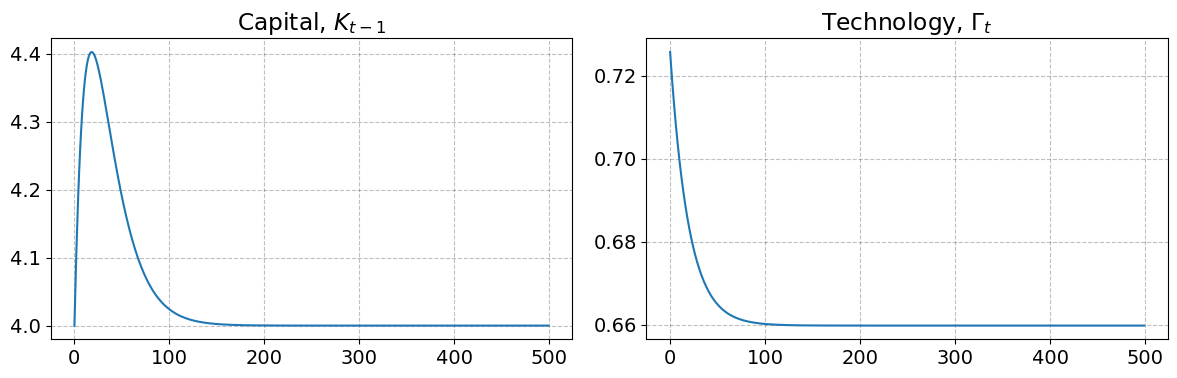

In [12]:
fig = plt.figure(figsize=(2*6,6/1.5))

ax = fig.add_subplot(1,2,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(path.K_lag)

ax = fig.add_subplot(1,2,2)
ax.plot(path.Gamma)
ax.set_title('Technology, $\Gamma_t$')

fig.tight_layout()

**Question:** Could a much more persistent shock be problematic?

## 5. <a id='toc5_'></a>[Future persistent technology shock](#toc0_)

**Shock happing after period $J$:**

In [13]:
par.K_lag_ini = ss.K # start from steady state

# shock
J = 50
path.Gamma[:] = ss.Gamma
path.Gamma[J:] = 0.95**np.arange(par.Tpath-J)*0.1*ss.Gamma + ss.Gamma

**Solve:**

In [14]:
model.solve()

 it =   0 -> max. abs. error =   0.10000000
 it =   1 -> max. abs. error =   0.00267237
 it =   2 -> max. abs. error =   0.00015130
 it =   3 -> max. abs. error =   0.00000241
 it =   4 -> max. abs. error =   0.00000025
 it =   5 -> max. abs. error =   0.00000002
 it =   6 -> max. abs. error =   0.00000000


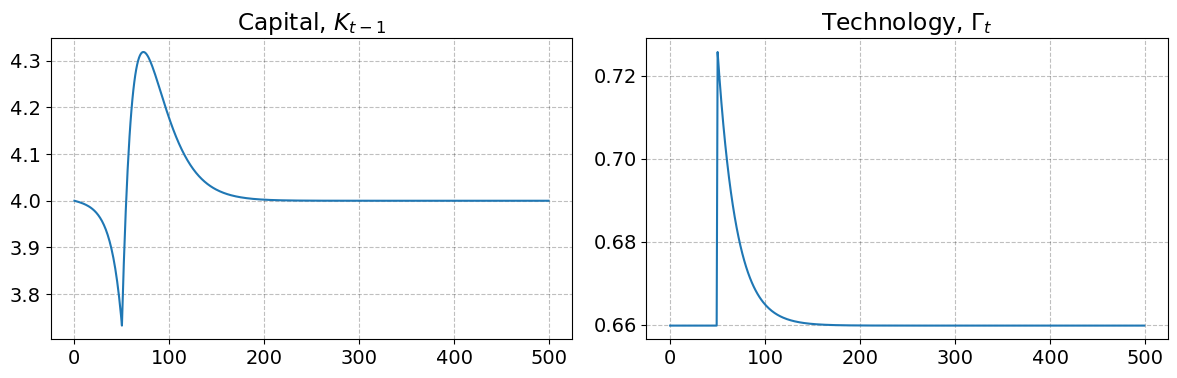

In [15]:
fig = plt.figure(figsize=(2*6,6/1.5))

ax = fig.add_subplot(1,2,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(path.K_lag)

ax = fig.add_subplot(1,2,2)
ax.plot(path.Gamma)
ax.set_title('Technology, $\Gamma_t$')

fig.tight_layout()

**Take-away:** Households are forward looking and responds before the shock hits.

## 6. <a id='toc6_'></a>[Potential analysis and extensions](#toc0_)

**Potential analysis:**

1. Permanent shocks ($\rightarrow$ convergence to new steady state)
2. Different shocks (e.g. discount factor)
3. Multiple shocks
4. Transition speed

**Extensions:**

1. Add a government and taxation
2. Endogenous labor supply
3. Additional assets (e.g. housing)
4. Add nominal rigidities (New Keynesian)

## 7. <a id='toc7_'></a>[Further perspectives](#toc0_)

**The next steps beyond this course:** 

1. The **Bewley-Huggett-Aiyagari** model. Households are heterogenous and make decisions under uncertainty and borrowing constraints as in *Dynamic optimization* lecture. See [Quantitative Macroeconomics with Heterogeneous Households](https://www.annualreviews.org/doi/abs/10.1146/annurev.economics.050708.142922). 

1. The **Heterogenous Agent New Keynesian (HANK)** model. A **Bewley-Huggett-Aiyagari** model *with nominal rigidities*.

Numerical solution of these models are covered in **Advanced Macroeconomics: Heterogenous Agent Models** ([course page](https://sites.google.com/view/numeconcph-advmacrohet/)).

